In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from dateutil import parser

df = pd.read_csv('resources/data_v2.csv')

def parse_mixed_date(date_str):
    try:
        return parser.parse(date_str, dayfirst=True)
    except Exception:
        return pd.NaT

# df = df.iloc[:-8]
df['Scan date'] = df['Scan date'].astype(str).apply(parse_mixed_date)
df['Commit frequency'] = df['Commit frequency'].str.capitalize()
# df['Scan date'] = pd.to_datetime(df['Scan date'], errors='coerce', dayfirst=False)
label_map = {
    'Unknown': 0,
    'Low': 1,
    'Medium': 2,
    'High': 3,
    'Critical': 4
}
df['Evaluate'] = df["Evaluate"].map(label_map)


df_copy = df.loc[:, (df != 0).any(axis=0)]
df_copy = df_copy.drop(labels=['Sprint'], axis=1)

In [2]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656 entries, 0 to 655
Data columns (total 13 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   Change code line number                                656 non-null    int64         
 1   Number of vulnerable modules                           656 non-null    int64         
 2   Number of people involved in development               656 non-null    int64         
 3   Time to complete each version                          656 non-null    object        
 4   Commit frequency                                       656 non-null    object        
 5   Type of environment                                    656 non-null    object        
 6   Number of libraries detected errors                    656 non-null    int64         
 7   Scan date                                              656 non-null    

In [3]:
df_copy

,Change code line number,Number of vulnerable modules,Number of people involved in development,Time to complete each version,Commit frequency,Type of environment,Number of libraries detected errors,Scan date,Number of potential weaknesses,Severity of the threat,Number of environmental configuration vulnerabilities,Evaluate,Repo
0,6,1,3,5 days,Weekly,Cloud,20,2025-02-28,24,5,4,2,admin-topik
1,78,1,4,5 days,Weekly,Cloud,20,2025-03-03,24,5,4,2,admin-topik
2,77,1,4,5 days,Weekly,Cloud,20,2025-05-03,24,5,4,2,admin-topik
3,62,1,4,5 days,Weekly,Cloud,20,2025-06-03,24,5,4,2,admin-topik
4,184,1,4,5 days,Weekly,Cloud,22,2025-07-03,26,5,4,2,admin-topik
...,...,...,...,...,...,...,...,...,...,...,...,...,...
651,351,1,1,7 days,Weekly,Cloud,24,2025-03-05,24,4,0,1,angular-weather
652,213,1,1,7 days,Weekly,Cloud,24,2025-03-09,24,4,0,1,angular-weather
653,88,1,1,7 days,Weekly,Cloud,24,2025-03-11,24,4,0,1,angular-weather
654,96,1,1,7 days,Weekly,Cloud,24,2025-03-13,24,4,0,1,angular-weather


In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

def preprocess_timeseries_dataframe(df: pd.DataFrame):
    df = df.copy()
    df = df.loc[:, (df != 0).any(axis=0)]
    df = df.drop(labels=['Sprint'], axis=1)
    df['Scan date'] = pd.to_datetime(df['Scan date'])

    categorical_columns = ['Time to complete each version', 'Commit frequency', 'Type of environment', 'Repo']
    group_sum_col = 'Change code line number'
    target_col = 'Evaluate'
    date_col = 'Scan date'

    all_dfs = []
    for repo, group in df.groupby('Repo'):
        # group by date to avoid duplicates before reindexing
        group = group.groupby(date_col).agg({
            group_sum_col: 'sum',
            'Number of vulnerable modules': 'mean',
            'Number of people involved in development': 'mean',
            'Number of libraries detected errors': 'mean',
            'Number of potential weaknesses': 'mean',
            'Severity of the threat': 'mean',
            'Number of environmental configuration vulnerabilities': 'mean',
            target_col: 'first',
            **{col: 'first' for col in categorical_columns}
        }).sort_index()

        # create full date index and reindex
        all_dates = pd.date_range(start=group.index.min(), end=group.index.max(), freq='D')
        group = group.reindex(all_dates, method='ffill')
        group[date_col] = group.index
        group['Repo'] = repo

        # identify filled-in rows and set code line to 0
        original_dates = df[df['Repo'] == repo]['Scan date'].unique()
        group[group_sum_col] = group[group_sum_col].where(group.index.isin(original_dates), 0)

        all_dfs.append(group)

    df_filled = pd.concat(all_dfs).reset_index(drop=True)

    # encode categoricals
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df_filled[col] = le.fit_transform(df_filled[col])
        label_encoders[col] = le

    # normalize features (excluding Scan date, Repo, Evaluate)
    feature_cols = df_filled.columns.difference([date_col, 'Repo', target_col])
    scaler = StandardScaler()
    df_filled[feature_cols] = scaler.fit_transform(df_filled[feature_cols])

    # final outputs
    X = df_filled.drop(columns=[date_col, 'Repo', target_col])
    y = df_filled[target_col]
    meta = df_filled[[date_col, 'Repo']]

    return X, y, meta, label_encoders, scaler

In [5]:
X, y, meta, encoders, scaler = preprocess_timeseries_dataframe(df)
X

,Change code line number,Number of vulnerable modules,Number of people involved in development,Number of libraries detected errors,Number of potential weaknesses,Severity of the threat,Number of environmental configuration vulnerabilities,Time to complete each version,Commit frequency,Type of environment
0,2.732049,-0.075755,-0.227043,0.568592,0.615446,0.104958,0.509871,-1.522841,-0.117946,0.0
1,1.971695,-0.075755,-0.151102,1.657167,1.705330,0.104958,0.509871,1.366229,1.022471,0.0
2,1.102975,-0.075755,-1.062385,0.375680,0.422302,0.104958,0.509871,-0.078306,-0.117946,0.0
3,1.049239,-0.075755,0.760180,-0.726674,-0.681377,0.104958,0.509871,-0.078306,-0.117946,0.0
4,-0.397135,-0.075755,0.760180,-0.726674,-0.681377,0.104958,0.509871,-0.078306,-0.117946,0.0
...,...,...,...,...,...,...,...,...,...,...
1397,-0.397135,-0.075755,0.532360,-1.691234,-1.647097,-1.330657,0.509871,-1.522841,-0.117946,0.0
1398,-0.397135,-0.075755,0.532360,-1.691234,-1.647097,-1.330657,0.509871,-1.522841,-0.117946,0.0
1399,-0.179507,-0.075755,1.671463,1.863859,1.912270,-1.330657,0.509871,1.366229,1.022471,0.0
1400,-0.397135,-0.075755,1.671463,1.863859,1.912270,-1.330657,0.509871,1.366229,1.022471,0.0


In [6]:
y

0       2
1       2
2       2
3       2
4       2
       ..
1397    3
1398    3
1399    3
1400    3
1401    3
Name: Evaluate, Length: 1402, dtype: int64

In [7]:
meta

,Scan date,Repo
0,2025-01-01,0
1,2025-01-02,0
2,2025-01-03,0
3,2025-01-04,0
4,2025-01-05,0
...,...,...
1397,2025-11-29,8
1398,2025-11-30,8
1399,2025-12-01,8
1400,2025-12-02,8


In [8]:
ori_X = scaler.inverse_transform(X[list(scaler.feature_names_in_)]).astype(int)
ori_X = pd.DataFrame(data=ori_X, columns=list(scaler.feature_names_in_))

In [9]:
for col in ('Time to complete each version', 'Commit frequency', 'Type of environment'):
    ori_X[col] = encoders[col].inverse_transform(ori_X[col])

In [10]:
ori_X

,Change code line number,Commit frequency,Number of environmental configuration vulnerabilities,Number of libraries detected errors,Number of people involved in development,Number of potential weaknesses,Number of vulnerable modules,Severity of the threat,Time to complete each version,Type of environment
0,3494,Monthly,4,31,3,35,1,4,10 days,Cloud
1,2645,Weekly,4,44,4,48,1,4,7 days,Cloud
2,1675,Monthly,4,29,2,33,1,4,5 days,Cloud
3,1615,Monthly,4,15,6,19,1,4,5 days,Cloud
4,0,Monthly,4,15,6,19,1,4,5 days,Cloud
...,...,...,...,...,...,...,...,...,...,...
1397,0,Monthly,4,4,5,8,1,3,10 days,Cloud
1398,0,Monthly,4,4,5,8,1,3,10 days,Cloud
1399,243,Weekly,4,47,8,51,1,3,7 days,Cloud
1400,0,Weekly,4,47,8,51,1,3,7 days,Cloud


In [11]:
ori_meta  = meta.copy()
ori_meta['Repo'] = encoders['Repo'].inverse_transform(ori_meta['Repo'])
ori_meta

,Scan date,Repo
0,2025-01-01,admin-jlpt
1,2025-01-02,admin-jlpt
2,2025-01-03,admin-jlpt
3,2025-01-04,admin-jlpt
4,2025-01-05,admin-jlpt
...,...,...
1397,2025-11-29,user-management
1398,2025-11-30,user-management
1399,2025-12-01,user-management
1400,2025-12-02,user-management


In [12]:
ori_y = pd.DataFrame(data=y, columns=['Evaluate'])
ori_y

,Evaluate
0,2
1,2
2,2
3,2
4,2
...,...
1397,3
1398,3
1399,3
1400,3


In [13]:
col_names = list(ori_X.columns) + list(ori_meta.columns) + list(ori_y.columns)
ori_data = pd.concat([ori_X, ori_meta, ori_y], ignore_index=True, axis=1)
ori_data.columns = col_names
ori_data = ori_data[df_copy.columns.tolist()]
ori_data.to_csv('resources/data_cleaned_v2.csv', index=False)

### Model

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

class BayesianDense(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.w_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.w_sigma = nn.Parameter(torch.Tensor(out_features, in_features))
        self.b_mu = nn.Parameter(torch.Tensor(out_features))
        self.b_sigma = nn.Parameter(torch.Tensor(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_normal_(self.w_mu, mode='fan_in')
        nn.init.constant_(self.w_sigma, -3)
        nn.init.constant_(self.b_mu, 0.1)
        nn.init.constant_(self.b_sigma, -3)

    def forward(self, x):
        w = Normal(self.w_mu, torch.exp(self.w_sigma)).rsample()
        b = Normal(self.b_mu, torch.exp(self.b_sigma)).rsample()
        return F.linear(x, w, b)

class MyModel(nn.Module):
    def __init__(self, input_features=10, timesteps=5, num_classes=5):
        super().__init__()
        assert input_features == 10, 'only 10 features supported right now'

        self.input_dense = BayesianDense(input_features, 32)
        self.lstm = nn.LSTM(32, 64, num_layers=2, batch_first=True)

        self.bayesian_layers = nn.ModuleList([
            BayesianDense(64, 64),
            BayesianDense(64, 48),
            BayesianDense(48, 48),
            BayesianDense(48, 32)
        ])

        self.dropout = nn.Dropout(0.1)
        self.final_dense = BayesianDense(32, num_classes)

        self.swish = lambda x: x * torch.sigmoid(x)

    def forward(self, x):
        batch_size, T, _ = x.shape

        x = self.swish(self.input_dense(x))  # (batch, T, 32)
        lstm_out, _ = self.lstm(x)  # (batch, T, 64)

        x = lstm_out
        for layer in self.bayesian_layers:
            x = self.swish(layer(x))

        x = self.dropout(x)
        logits = self.final_dense(x)  # (batch, T, num_classes)
        return logits
    
def evaluate(model, loader, verbose=True):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x_batch, y_batch in loader:
            output = model(x_batch)  # (batch, T, num_classes)
            preds = output.argmax(dim=-1)
            all_preds.append(preds.flatten())
            all_labels.append(y_batch.flatten())
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    acc = (all_preds == all_labels).float().mean().item()
    if verbose:
        print(f"accuracy: {acc:.4f}")
    return acc

def train(model, loader, optimizer, criterion, val_loader=None, epochs=100):
    model.train()
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        total_loss = 0
        for x_batch, y_batch in loader:
            optimizer.zero_grad()
            output = model(x_batch)  # shape: (batch, T, num_classes)
            loss = criterion(output.view(-1, output.shape[-1]), y_batch.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        train_losses.append(avg_loss)

        # Validation accuracy
        if val_loader:
            acc = evaluate(model, val_loader, verbose=False)
            val_accuracies.append(acc)

        print(f"epoch {epoch+1}: loss = {avg_loss:.4f}" + (f", val. acc. = {acc:.4f}" if val_loader else ""))

    return train_losses, val_accuracies

In [15]:
from torch.utils.data import Dataset, DataLoader, random_split

# class RepoDataset(Dataset):
#     def __init__(self, X_df, y_series, meta_df, timesteps=5):
#         self.samples = []
#         self.meta = []

#         grouped = meta_df.groupby("Repo")
#         for repo_id, group_indices in grouped.groups.items():
#             group = meta_df.loc[group_indices].sort_values("Scan date")
#             sorted_idx = group.index.tolist()
#             if len(sorted_idx) < timesteps:
#                 continue
#             for i in range(len(sorted_idx) - timesteps + 1):
#                 window_idx = sorted_idx[i:i + timesteps]
#                 x_seq = torch.tensor(X_df.loc[window_idx].values, dtype=torch.float32)
#                 y_seq = torch.tensor(y_series.loc[window_idx].values, dtype=torch.long)
#                 # meta_seq = meta_df.loc[window_idx].iloc[-1]
#                 self.samples.append((x_seq, y_seq))

#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self, idx):
#         return self.samples[idx]
    
# train_repos = [0, 1, 2]
# test_repos = [3]

# train_mask = meta['Repo'].isin(train_repos)
# test_mask = meta['Repo'].isin(test_repos)

# X_train = X[train_mask]
# y_train = y[train_mask]
# meta_train = meta[train_mask]

# X_test = X[test_mask]
# y_test = y[test_mask]
# meta_test = meta[test_mask]

# timesteps = 5
# train_dataset = RepoDataset(X_train, y_train, meta_train, timesteps=timesteps)
# test_dataset = RepoDataset(X_test, y_test, meta_test, timesteps=timesteps)

# batch_size = 32
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [16]:
# model = MyModel(input_features=10, timesteps=timesteps, num_classes=5)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()

# train_losses, val_accuracies = train(
#     model, train_loader, optimizer, criterion,
#     val_loader=test_loader, epochs=200
# )

# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(train_losses)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Loss')
# plt.grid(True)

# plt.subplot(1, 2, 2)
# plt.plot(val_accuracies, color='green')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Accuracy')
# plt.grid(True)

# plt.tight_layout()
# plt.show()

In [17]:
class RepoSplitTimeSeriesDataset(Dataset):
    def __init__(self, X_df, y_series, meta_df, timesteps=5, mode="train", split_ratio=0.8):
        self.samples = []
        assert mode in ["train", "val"], "mode must be 'train' or 'val'"

        grouped = meta_df.groupby("Repo")

        for repo_id, group_indices in grouped.groups.items():
            # sort by time within each repo
            group = meta_df.loc[group_indices].sort_values("Scan date")
            sorted_idx = group.index.tolist()

            total = len(sorted_idx)
            split_point = int(total * split_ratio)

            if total < timesteps:
                continue  # skip short repos

            if mode == "train":
                use_idx = sorted_idx[:split_point]
            else:  # val
                use_idx = sorted_idx[split_point:]

            # re-slide within the selected portion
            for i in range(len(use_idx) - timesteps + 1):
                window_idx = use_idx[i:i + timesteps]
                x_seq = torch.tensor(X_df.loc[window_idx].values, dtype=torch.float32)
                y_seq = torch.tensor(y_series.loc[window_idx].values, dtype=torch.long)
                meta_seq = meta_df.loc[window_idx].iloc[-1].to_dict()
                self.samples.append((x_seq, y_seq))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]
    

timesteps = 5
train_dataset = RepoSplitTimeSeriesDataset(X, y, meta, timesteps=timesteps, mode="train", split_ratio=0.1)
val_dataset = RepoSplitTimeSeriesDataset(X, y, meta, timesteps=timesteps, mode="val", split_ratio=0.1)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [18]:
len(train_dataset)

110

epoch 1: loss = 1.6933, val. acc. = 0.0502
epoch 2: loss = 1.6814, val. acc. = 0.0065
epoch 3: loss = 1.6224, val. acc. = 0.0024
epoch 4: loss = 1.7223, val. acc. = 0.1475
epoch 5: loss = 1.6616, val. acc. = 0.1734
epoch 6: loss = 1.6225, val. acc. = 0.2005
epoch 7: loss = 1.6009, val. acc. = 0.2193
epoch 8: loss = 1.6407, val. acc. = 0.2052
epoch 9: loss = 1.6351, val. acc. = 0.3422
epoch 10: loss = 1.5812, val. acc. = 0.2918
epoch 11: loss = 1.5801, val. acc. = 0.3435
epoch 12: loss = 1.5450, val. acc. = 0.3821
epoch 13: loss = 1.5582, val. acc. = 0.5043
epoch 14: loss = 1.5644, val. acc. = 0.6021
epoch 15: loss = 1.5316, val. acc. = 0.5695
epoch 16: loss = 1.4985, val. acc. = 0.4866
epoch 17: loss = 1.4703, val. acc. = 0.7110
epoch 18: loss = 1.4258, val. acc. = 0.7072
epoch 19: loss = 1.3696, val. acc. = 0.6580
epoch 20: loss = 1.3383, val. acc. = 0.7176
epoch 21: loss = 1.4139, val. acc. = 0.7180
epoch 22: loss = 1.3348, val. acc. = 0.6811
epoch 23: loss = 1.3058, val. acc. = 0.72

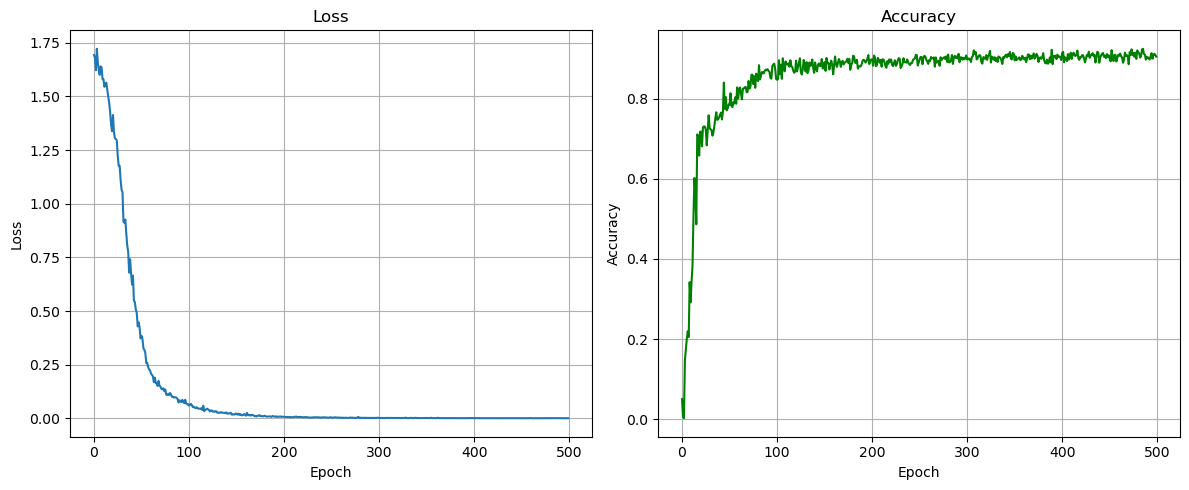

In [19]:
model = MyModel(input_features=10, timesteps=timesteps, num_classes=5)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

train_losses, val_accuracies = train(
    model, train_loader, optimizer, criterion,
    val_loader=val_loader, epochs=500
)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

In [20]:
print(y.value_counts(normalize=True))

Evaluate
2    0.705421
3    0.240371
1    0.054208
Name: proportion, dtype: float64
